In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload  # Python 3.4+

from sklearn import metrics
import seaborn as sns
sns.set()

from sklearn.calibration import CalibratedClassifierCV

from IPython.display import clear_output, display

In [2]:
train_df = pd.read_csv('train_for_2012.csv',index_col=0)
train_df.shape

(837913, 43)

In [3]:
test_df = pd.read_csv('test_for_2012.csv',index_col=0)
test_df.shape

(185639, 43)

In [4]:
# df['is_first_occurrence'] = (df['id'] != df['id'].shift()).astype(int)

In [5]:
# modeling_df = df[df['is_first_occurrence']==1].copy()
# print(modeling_df.shape)
# len(modeling_df)/len(df)

In [6]:
train_df['stmt_date'] = pd.to_datetime(train_df['stmt_date'])
train_df['def_date'] = pd.to_datetime(train_df['def_date'], format="%d/%m/%Y")
train_df.sort_values('stmt_date', inplace=True)

In [7]:
### we'll try dropping NA's for now
train_df.sort_values('stmt_date', inplace=True)

## Get preprocessing data ready

In [10]:
from preproc_functions import pre_process

In [11]:
with open('quantile_custom_bins.pkl', 'rb') as file:
    custom_bins = pickle.load(file)

In [12]:
preproc_params = {
    'quantile_bins' : {},
    'quantile_values' : {}
}

In [13]:
train_data_proc , preproc_params = pre_process(train_df, 
                                               custom_bins=custom_bins, 
                                               preproc_params = preproc_params,  
                                               quantiles = 50, 
                                               days_until_statement = 150)

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile
Custom bins for net_income_growth_quantile


## Train algorithm

In [14]:
### features for first firm
first_features = [
    'asst_tot_quantile_values',
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    # 'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    # 'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',
    'dscr_quantile_values',
    'roe_quantile_values',
    # 'ebitda',
]


In [15]:
### features for recurring firms
rec_features = [
    'asst_tot_quantile_values',
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',
    'dscr_quantile_values',
    'roe_quantile_values',
    # 'ebitda',

]

In [16]:
first_formula = 'default ~ '+' + '.join(first_features)
first_formula

'default ~ asst_tot_quantile_values + financial_leverage_quantile_values + profitability_ratio_quantile_values + quick_ratio_v2_quantile_values + cash_assets_ratio_quantile_values + dscr_quantile_values + roe_quantile_values'

In [17]:
rec_formula = 'default ~ '+' + '.join(rec_features)
rec_formula

'default ~ asst_tot_quantile_values + financial_leverage_quantile_values + profitability_ratio_quantile_values + net_income_growth_quantile_values + quick_ratio_v2_quantile_values + sales_growth_quantile_values + cash_assets_ratio_quantile_values + dscr_quantile_values + roe_quantile_values'

In [18]:
class SplitModel():
    def __init__(self, algo):
        self.first_formula = 'default ~ '+' + '.join(first_features)
        self.rec_formula = 'default ~ '+' + '.join(rec_features)

        self.algo = algo
    
    def train(self, data):
        
        rec_data = data[data['is_first_occurrence']==0]
        first_data = data[data['is_first_occurrence']==1]
        
        self.first_model = self.algo(self.first_formula, data = first_data)
        self.first_fitted_model = self.first_model.fit()

        self.rec_model = self.algo(self.rec_formula, data = rec_data)
        self.rec_fitted_model = self.rec_model.fit()
        print("models fit")

    def predict(self, data):
        rec_data = data[data['is_first_occurrence']==0]
        first_data = data[data['is_first_occurrence']==1]
        print('rec data length',len(rec_data))
        print('first data length',len(first_data))
        
        rec_preds = self.rec_fitted_model.predict(rec_data)
        rec_preds = rec_preds.reindex(rec_data.index)
        
        first_preds = self.first_fitted_model.predict(first_data)
        first_preds = first_preds.reindex(first_data.index)

        predictions = pd.concat([rec_preds,first_preds]).reindex(data.index)
        
        return predictions

    def summary(self):
        print('~~~~~ First Time First Model ~~~~~~')
        print(self.first_fitted_model.summary())
        print(self.first_fitted_model.get_margeff().summary())
        print('\n')
        print('~~~~~ Recurring First Model ~~~~~~')
        print(self.rec_fitted_model.summary())
        print(self.rec_fitted_model.get_margeff().summary())
        print('\n')
        

In [19]:
model = SplitModel(algo=smf.logit)

In [20]:
model.train(train_data_proc)

Optimization terminated successfully.
         Current function value: 0.050667
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.063442
         Iterations 10
models fit


In [21]:
preds = model.predict(train_data_proc)

rec data length 612920
first data length 224993


### Model results

In [22]:
model.summary()

~~~~~ First Time First Model ~~~~~~
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:               224993
Model:                          Logit   Df Residuals:                   224985
Method:                           MLE   Df Model:                            7
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.1067
Time:                        10:23:38   Log-Likelihood:                -11400.
converged:                       True   LL-Null:                       -12761.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -7.1931      0.221    -32.564      0.000      -7.626      -6.760
asst_tot_quantile_va

## Process test data

In [23]:
test_df['stmt_date'] = pd.to_datetime(test_df['stmt_date'])
test_df['def_date'] = pd.to_datetime(test_df['def_date'], format="%d/%m/%Y")
test_df.sort_values('stmt_date', inplace=True)

In [24]:
test_data_proc , preproc_params = pre_process(test_df, 
                                             historical_df=train_data_proc, 
                                             new=False, 
                                             preproc_params = preproc_params,  
                                             quantiles = 50, 
                                             days_until_statement = 150)

asst_tot_quantile
financial_leverage_quantile
profitability_ratio_quantile
roe_quantile
net_income_growth_quantile
quick_ratio_v2_quantile
sales_growth_quantile
cash_assets_ratio_quantile
dscr_quantile


In [25]:
test_predictions = model.predict(test_data_proc)

rec data length 172921
first data length 12718


In [26]:
test_results = test_data_proc[['default']].copy()
test_results['predictions'] = test_predictions

In [27]:
test_results.head()

,default,predictions
Unnamed: 0,,
21,0,0.096428
2757816,0,0.104018
2757825,0,0.013074
2757832,0,0.005334
2757853,0,0.003629


In [28]:
metrics.roc_auc_score(y_score=test_results['predictions'], y_true=test_results['default'])

np.float64(0.8406422816938761)

ROC AUC 0.8406422816938761


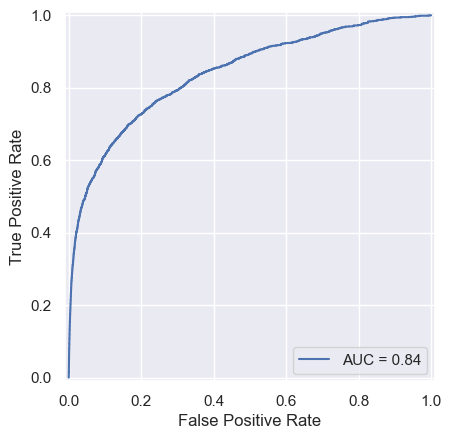

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(test_results['default'], test_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [30]:
# train_data_proc.to_csv('train_processed_data_for_2012.csv', index=False)
# test_data_proc.to_csv('test_processed_data_for_2012.csv', index=False)

## saving components for harness

In [31]:
growth_features = [
    'id',
    'stmt_date',
    'net_income',
    'sales'
]

In [35]:
historical_growth = train_data_proc[growth_features]#.to_csv('historical_features.csv')
historical_growth.head()

,id,stmt_date,net_income,sales
Unnamed: 0,,,,
22,520288,2007-12-31,36733.0,2041155.0
18,520288,2008-12-31,-107382.0,967389.0
19,520288,2009-12-31,-77819.0,638687.0
23,520288,2010-12-31,-83593.0,564622.0
17,520288,2011-12-31,-81288.0,538081.0


In [36]:
historical_growth.to_csv('historical_features.csv')

In [38]:
with open('custom_bins.pkl', 'wb') as output:
    pickle.dump(custom_bins, output)

In [39]:
with open('preproc_params.pkl', 'wb') as output:
    pickle.dump(preproc_params, output)

In [41]:
with open('trained_model.pkl', 'wb') as output:
    pickle.dump(model, output)